<a href="https://colab.research.google.com/github/fressbish/Koptev-Dmitry/blob/main/task2_gnn_KoptevDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Коптев Д.А., GNN, Задание 2


## Задача 2. Node embeddings

 - Найти набор данных для бинарной классификации рёбер в графе.
 - Реализовать случайные блуждания алгоритма DeepWalk и построить множества схожих вершин
 - Обучить эмбеддинги вершин, используя SGD и negative sampling.
 - Визуализировать эмбеддинги.
 - (+5 баллов) Также реализовать node2vec блуждания и обучить классификатор, используя его. Сравнить результаты.

In [1]:
import pandas as pd
import numpy as np
import random

import networkx as nx
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

### **Датасет**
https://snap.stanford.edu/data/ego-Twitter.html

In [2]:
!tar -xvzf "/content/twitter.tar.gz" -C /content/

twitter/
twitter/21028234.feat
twitter/30031265.circles
twitter/745823.feat
twitter/66804457.featnames
twitter/14372486.feat
twitter/1435461.featnames
twitter/19283723.featnames
twitter/398994309.feat
twitter/11681802.edges
twitter/86560711.featnames
twitter/13747362.egofeat
twitter/143344048.egofeat
twitter/48132655.circles
twitter/266464616.featnames
twitter/31317273.edges
twitter/232706326.featnames
twitter/120459837.egofeat
twitter/54331626.egofeat
twitter/17135931.edges
twitter/317313520.egofeat
twitter/51775432.edges
twitter/121258930.featnames
twitter/258447233.circles
twitter/14848513.feat
twitter/17384099.egofeat
twitter/17922109.feat
twitter/20446839.featnames
twitter/333966373.feat
twitter/6650612.circles
twitter/14256927.circles
twitter/258955239.egofeat
twitter/21061498.egofeat
twitter/1046661.feat
twitter/378494343.circles
twitter/170167167.feat
twitter/819800.feat
twitter/26083291.featnames
twitter/163491360.egofeat
twitter/180540375.circles
twitter/15797184.egofeat
twit

In [3]:
df = pd.read_csv(os.path.join('.', 'twitter/12831.edges'),
                       delimiter=' ',
                       header=None,
                       names=['node1', 'node2'])
df

,node1,node2
0,398874773,652193
1,18498878,14749606
2,14305022,8479062
3,22253,12741
4,15540222,14809096
...,...,...
2473,17459034,652193
2474,13462502,377821426
2475,14178728,528
2476,9767472,14819149


In [4]:
G = nx.from_pandas_edgelist(df, 'node1', 'node2', create_using=nx.Graph())
G.number_of_nodes(), G.number_of_edges()

(236, 1811)

### **DeepWalk**

In [5]:
# параметры
embedding_dim = 100
learning_rate = 0.005
epochs = 15
num_paths_per_node = 8
path_length = 30
count_negative_samples = len(G.edges())

# вектора для вершин
node_vectors = {node: np.random.rand(embedding_dim) for node in G.nodes()}

# создаем пути для случайного блуждания
def create_random_path(graph, start, length):
    path = [start]
    for _ in range(length - 1):
        neighbors = list(graph.neighbors(path[-1]))
        if neighbors:
            path.append(random.choice(neighbors))
        else:
            break
    return path

paths = [
    create_random_path(G, node, path_length)
    for node in G.nodes()
    for _ in range(num_paths_per_node)
]

# генерируем контекстные пары для каждого пути
context_window = 6

def extract_center_context_pairs(path, window):
    pairs = []
    for idx, center in enumerate(path):
        start_idx = max(0, idx - window)
        end_idx = min(len(path), idx + window + 1)
        pairs.extend((center, path[context]) for context in range(start_idx, end_idx) if context != idx)
    return pairs

training_data = [pair for path in paths for pair in extract_center_context_pairs(path, context_window)]

In [6]:
training_data

[(398874773, 1260231),
 (398874773, 57378470),
 (398874773, 1186),
 (398874773, 18498878),
 (398874773, 14231571),
 (398874773, 528),
 (1260231, 398874773),
 (1260231, 57378470),
 (1260231, 1186),
 (1260231, 18498878),
 (1260231, 14231571),
 (1260231, 528),
 (1260231, 14305022),
 (57378470, 398874773),
 (57378470, 1260231),
 (57378470, 1186),
 (57378470, 18498878),
 (57378470, 14231571),
 (57378470, 528),
 (57378470, 14305022),
 (57378470, 14710479),
 (1186, 398874773),
 (1186, 1260231),
 (1186, 57378470),
 (1186, 18498878),
 (1186, 14231571),
 (1186, 528),
 (1186, 14305022),
 (1186, 14710479),
 (1186, 6331462),
 (18498878, 398874773),
 (18498878, 1260231),
 (18498878, 57378470),
 (18498878, 1186),
 (18498878, 14231571),
 (18498878, 528),
 (18498878, 14305022),
 (18498878, 14710479),
 (18498878, 6331462),
 (18498878, 5854882),
 (14231571, 398874773),
 (14231571, 1260231),
 (14231571, 57378470),
 (14231571, 1186),
 (14231571, 18498878),
 (14231571, 528),
 (14231571, 14305022),
 (1423157

### **SGD и negative sampling**

In [7]:
# негативные ребра
def generate_negative_edges(graph, num_samples):
    negative_edges = []
    existing_edges = set(graph.edges())
    while len(negative_edges) < num_samples:
        a, b = np.random.choice(list(graph.nodes()), 2)
        if a != b and (a, b) not in existing_edges and (b, a) not in existing_edges:
            negative_edges.append((a, b))
    return negative_edges

def calculate_sigmoid(value):
    return 1 / (1 + np.exp(-value))

def compute_edge_probability(node1, node2, vectors):
    return calculate_sigmoid(np.dot(vectors[node1], vectors[node2]))

# обновление эмбеддингов
def adjust_embeddings(node1, node2, target, vectors, rate):
    probability = compute_edge_probability(node1, node2, vectors)
    grad_node1 = (target - probability) * vectors[node2]
    vectors[node1] += rate * grad_node1

    grad_node2 = (target - probability) * vectors[node1]
    vectors[node2] += rate * grad_node2

In [8]:
# обучаем эмбеддинги в цикле
for e in range(epochs):
    for source, target in training_data:
        adjust_embeddings(source, target, target=1, vectors=node_vectors, rate=learning_rate)
    negative_samples = generate_negative_edges(G, count_negative_samples)
    for source, target in negative_samples:
        adjust_embeddings(source, target, target=0, vectors=node_vectors, rate=learning_rate)

    print('epoch', e)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14


### **Визуализация**

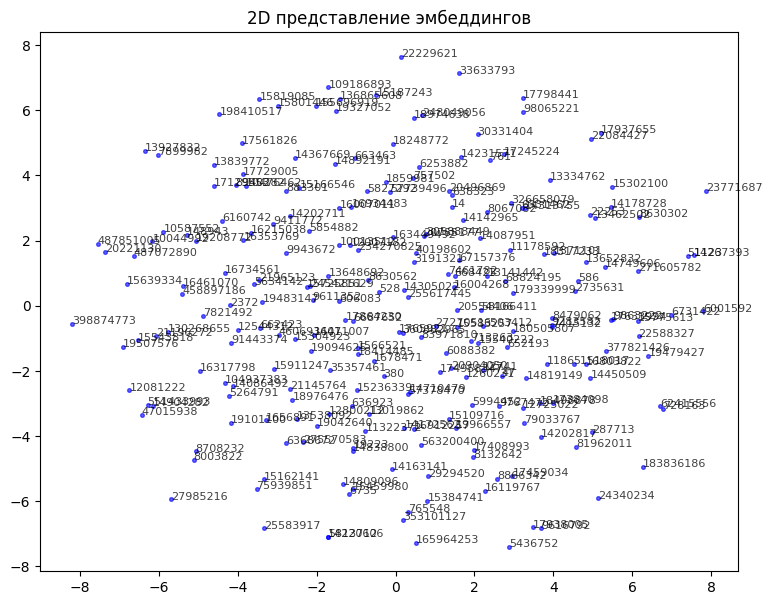

In [9]:
nodes = list(node_vectors.keys())
embeddings = np.array([node_vectors[n] for n in nodes])

# преобразуем эмбеддинги с помощью tsne
reducer = TSNE(n_components=2, init='pca', random_state=42)
embedded_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(9, 7))
plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], c='blue', s=7, alpha=0.6)
for idx, label in enumerate(nodes):
    plt.text(embedded_2d[idx, 0], embedded_2d[idx, 1], str(label), fontsize=8, alpha=0.75)

plt.title("2D представление эмбеддингов")
plt.show()

### **Обучаем классификатор**

In [10]:
edges_positive = list(G.edges())
edges_negative = generate_negative_edges(G, len(edges_positive))

# получаем признаки для ребер
def create_edge_features(node1, node2, embeddings):
    vec1, vec2 = embeddings[node1], embeddings[node2]
    return np.hstack([vec1, vec2])

features = np.array([create_edge_features(u, v, node_vectors) for u, v in edges_positive + edges_negative])
labels = np.array([1] * len(edges_positive) + [0] * len(edges_negative))

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, random_state=24)

# обучаем классификатор
model = LogisticRegression(max_iter=1200, random_state=24)
model.fit(features_train, labels_train)

# прогнозы
predictions = model.predict(features_test)
accuracy_score(labels_test, predictions), f1_score(labels_test, predictions)

(0.7373068432671082, 0.7520833333333333)